# Causal Reasoning meets Bayesian Inference with `CausalPy`

`CausalPy` supported by PyMC labs, whereas the CausalImpact library from Google is in R with translations to python in `pyCausalImpact` and `tfcausalimpact`. 

### Regression vs BSTS

Both `CausalPy` and `CausalImpact` offer similar functionality, but `CausalPy` allows for both `sklearn` and `pymc` (regression-based) models and they are continuing to expand. At this time, they don't support the BSTS model as seen in the original CausalImpact lirary. 

I also tried out `sts-jax` but the documentation was outdated and it looks like development has stopped. It took a little work to get it to work and when it did, it was still slow. It might be good for structural time series but haven't tried it - especially considering `pymc-experimental` added their own rendition and `sts-jax` hasn't been touched in a while. `tfcausalimpact` seems to be the most stable out of the bunch if we want something close to the R version and use BSTS as the preferred model.

## A `CausalPy` Example: What was the causal impact of Brexit?

From [PyData Global 2022: Benjanmin Vincent - What-if Causal reasoning meets Bayesian Inference](https://www.youtube.com/watch?v=gV6wzTk3o1U&t=8s)
* [Github repo](https://github.com/drbenvincent/pydata-global-2022)
* [Updated code in the documentation](https://causalpy.readthedocs.io/en/latest/notebooks/sc_pymc_brexit.html)
* [CausalPy Git Repo](https://github.com/pymc-labs/CausalPy)

In [1]:
import arviz as az
import causalpy as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from causalpy.pymc_models import WeightedSumFitter

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-white")

In [2]:
df = (
    cp.load_data("brexit")
    .assign(Time=lambda x: pd.to_datetime(x["Time"]))
    .set_index("Time")
    .loc[lambda x: x.index >= "2009-01-01"]
    # manual exclusion of some countries
    .drop(["Japan", "Italy", "US", "Spain", "Portugal"], axis=1)
)

# specify date of the Brexit vote announcement
treatment_time = pd.to_datetime("2016 June 24")
df.head()

Australia   Austria  Belgium    Canada  Denmark  Finland   France  \
Time                                                                            
2009-01-01    3.84048  0.802836  0.94117  16.93824  4.50096  0.51052  5.05450   
2009-04-01    3.86954  0.796545  0.94162  16.75340  4.41372  0.50829  5.05375   
2009-07-01    3.88115  0.799937  0.95352  16.82878  4.42898  0.51299  5.06237   
2009-10-01    3.91028  0.803823  0.96117  17.02503  4.43300  0.50903  5.09832   
2010-01-01    3.92716  0.800510  0.96615  17.23041  4.47128  0.51413  5.11625   

            Germany  Iceland  Luxemburg  Netherlands  New_Zealand   Norway  \
Time                                                                         
2009-01-01  6.63471  5.18157   0.114836     1.634391      0.47336  7.78753   
2009-04-01  6.64530  5.16171   0.116259     1.634432      0.47916  7.71903   
2009-07-01  6.68237  5.24132   0.118747     1.640982      0.48188  7.72400   
2009-10-01  6.73155  5.22482   0.119302     1.650866      0.48805  7.72812   
2010-01-01  6.78621  4.91128   0.121414     1.647748      0.49349  7.87891   

              Sweden  Switzerland       UK  
Time                                        
2009-01-01  10.32220     1.476532  4.61881  
2009-04-01  10.32867     1.485509  4.60431  
2009-07-01  10.32328     1.502506  4.60722  
2009-10-01  10.37107     1.515139  4.62152  
2010-01-01  10.64833     1.525864  4.65380

In [3]:
# get useful country lists
target_country = "UK"
all_countries = df.columns
other_countries = all_countries.difference({target_country})
all_countries = list(all_countries)
other_countries = list(other_countries)

## Data Visualization

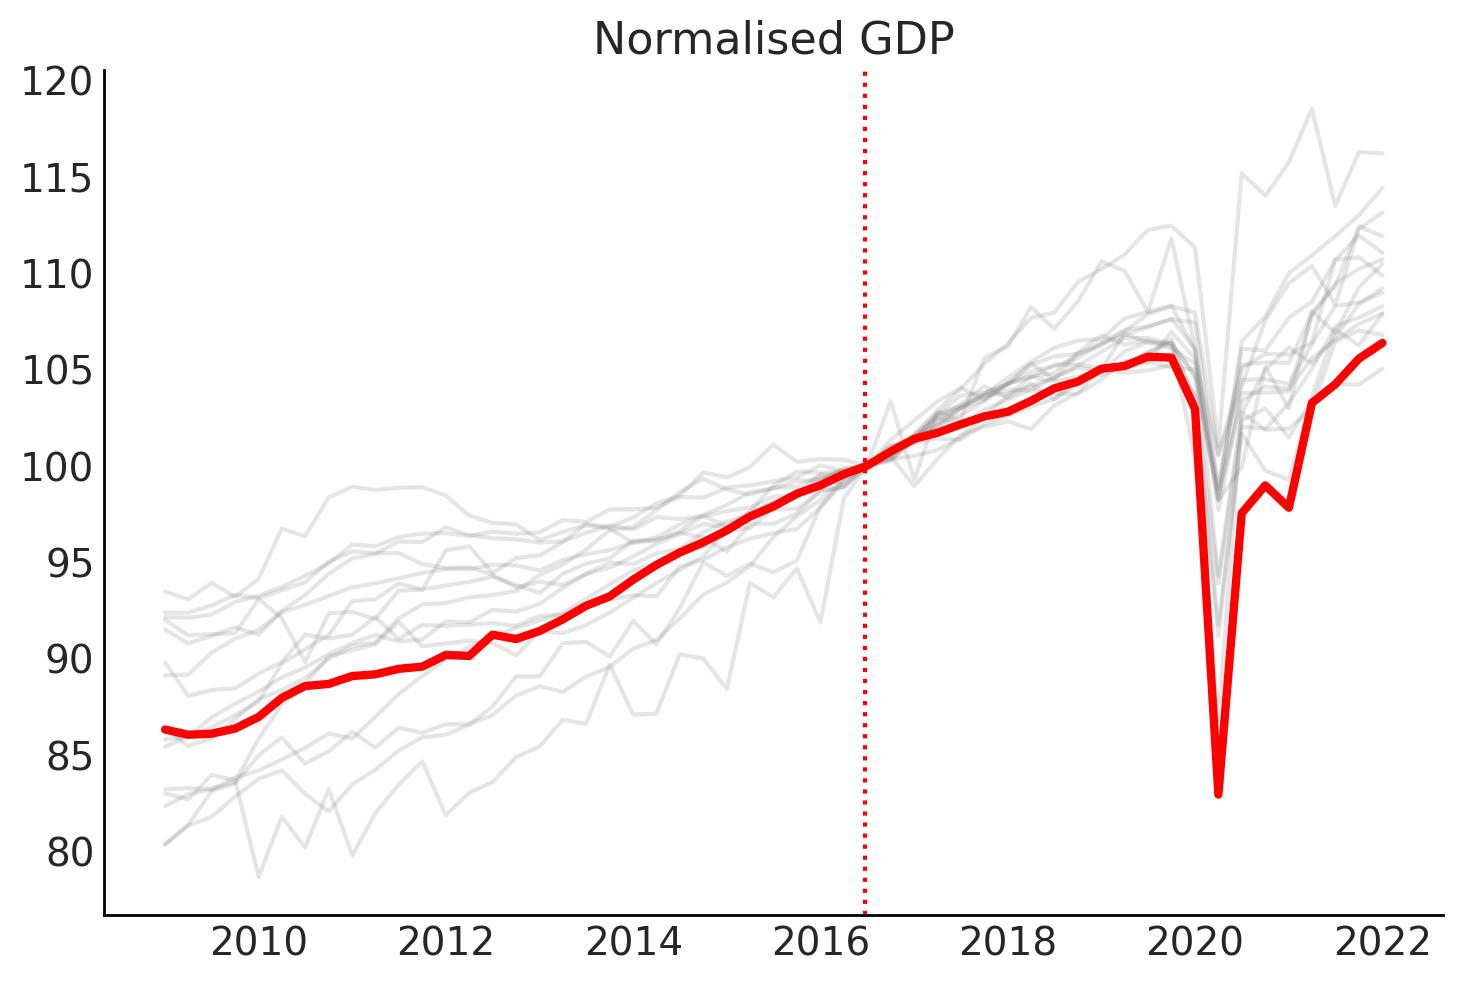

In [4]:
# Plot the time series normalised so that intervention point (Q3 2016) is equal to 100
gdp_at_intervention = df.loc[pd.to_datetime("2016 July 01"), :]
df_normalised = (df / gdp_at_intervention) * 100.0

# plot
fig, ax = plt.subplots()
for col in other_countries:
    ax.plot(df_normalised.index, df_normalised[col], color="grey", alpha=0.2)

ax.plot(df_normalised.index, df_normalised[target_country], color="red", lw=3)

# formatting
ax.set(title="Normalised GDP")
ax.axvline(x=treatment_time, color="r", ls=":");

# plt.savefig("img/brexit_GDP_normalised.png", bbox_inches="tight", dpi=300);

Estimate counterfactual as a weighted sum of untreated countries on the pre-treatment data.

To see if the other countries are similar to the UK, we can do a heatmap of the correlation plot below. We see that these countries are highly correlated with the UK and should be good candidates to use to make our synthetic control.

In [5]:
pre_intervention_data = df.loc[df.index > treatment_time, :]

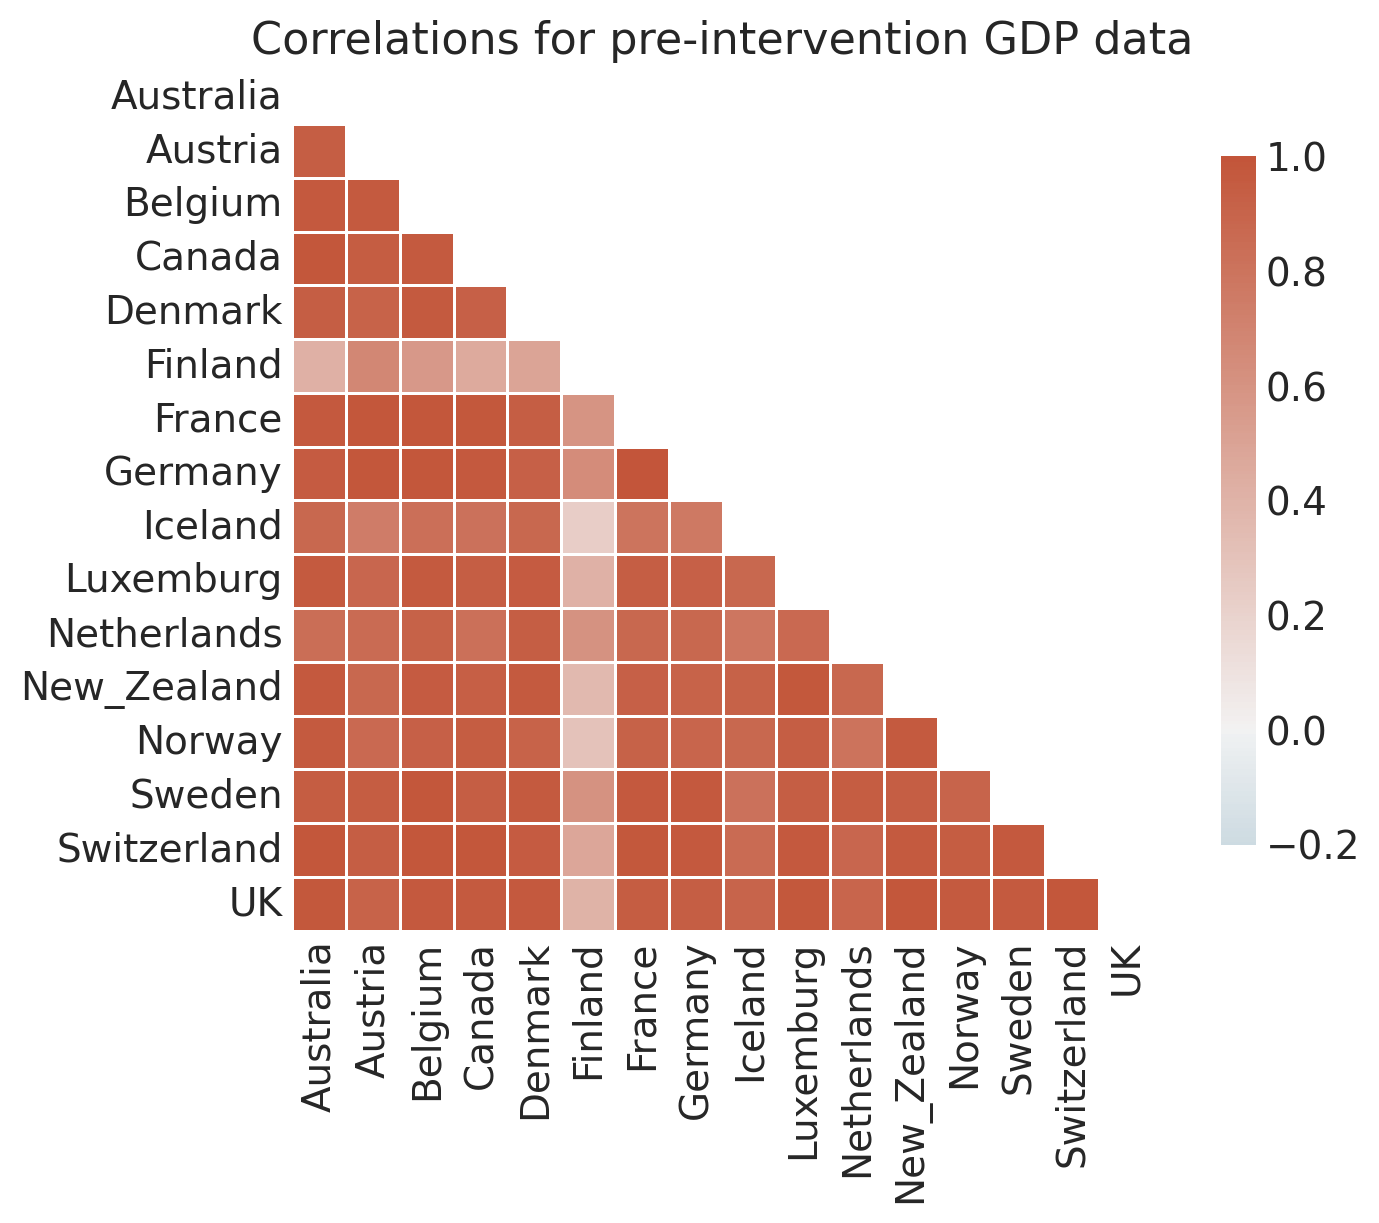

In [6]:
# Examine how correlated the pre-intervention time series are
pre_intervention_data = df.loc[df.index < treatment_time, :]

corr = pre_intervention_data.corr()

f, ax = plt.subplots(figsize=(8, 6))
ax = sns.heatmap(
    corr,
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    cmap=sns.diverging_palette(230, 20, as_cmap=True),
    vmin=-0.2,
    vmax=1.0,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
)
ax.set(title="Correlations for pre-intervention GDP data");

## Run Bayesian synthetic control with `CausalPy`

In this example we use an `R`-style (or `patsy`-style) regression formula and specify the model to be a weighted combination of the untreated countries.

In [7]:
# Specify model formula
formula = target_country + " ~ " + "0 + " + " + ".join(other_countries)

print(formula)

UK ~ 0 + Australia + Austria + Belgium + Canada + Denmark + Finland + France + Germany + Iceland + Luxemburg + Netherlands + New_Zealand + Norway + Sweden + Switzerland


In [8]:
# Call the `SyntheticControl` method
sample_kwargs = {"tune": 4000, "target_accept": 0.99, "random_seed": 42}

result = cp.pymc_experiments.SyntheticControl(
    df,
    treatment_time,
    formula=formula,
    model=WeightedSumFitter(sample_kwargs=sample_kwargs),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 292 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


Check $\hat{r}$ to see how well we're doing. Anything over 1.05 would be cause for concern, while values close to 1 mean that we don't necessarily have a problem.

In [9]:
az.summary(result.idata, var_names=["~mu"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
beta[Australia]    0.117  0.071   0.000    0.237      0.003    0.002   
beta[Austria]      0.044  0.040   0.000    0.119      0.001    0.001   
beta[Belgium]      0.051  0.045   0.000    0.134      0.001    0.001   
beta[Canada]       0.041  0.023   0.002    0.081      0.001    0.001   
beta[Denmark]      0.094  0.062   0.001    0.201      0.002    0.002   
beta[Finland]      0.042  0.039   0.000    0.117      0.001    0.001   
beta[France]       0.029  0.028   0.000    0.082      0.001    0.001   
beta[Germany]      0.025  0.026   0.000    0.070      0.001    0.001   
beta[Iceland]      0.156  0.040   0.083    0.231      0.001    0.001   
beta[Luxemburg]    0.053  0.047   0.000    0.142      0.002    0.001   
beta[Netherlands]  0.048  0.043   0.000    0.128      0.001    0.001   
beta[New_Zealand]  0.063  0.055   0.000    0.164      0.002    0.002   
beta[Norway]       0.076  0.045   0.000    0.148      0.002    0.002   
beta[Sweden]       0.097  0.031   0.040    0.155      0.001    0.001   
beta[Switzerland]  0.065  0.057   0.000    0.171      0.001    0.001   
sigma              0.031  0.005   0.023    0.040      0.000    0.000   

                   ess_bulk  ess_tail  r_hat  
beta[Australia]       525.0     343.0   1.01  
beta[Austria]         961.0     995.0   1.00  
beta[Belgium]         750.0     776.0   1.01  
beta[Canada]          338.0     652.0   1.02  
beta[Denmark]         638.0     546.0   1.00  
beta[Finland]         712.0     832.0   1.01  
beta[France]          396.0     405.0   1.02  
beta[Germany]         739.0     873.0   1.01  
beta[Iceland]        1005.0    1234.0   1.00  
beta[Luxemburg]       475.0     363.0   1.00  
beta[Netherlands]     721.0     748.0   1.01  
beta[New_Zealand]     385.0     324.0   1.01  
beta[Norway]          241.0     129.0   1.02  
beta[Sweden]          690.0     769.0   1.00  
beta[Switzerland]    3517.0    1978.0   1.00  
sigma                 701.0    1146.0   1.01

We can also use `az.plot_trace` on the result to see how our chains are looking: 

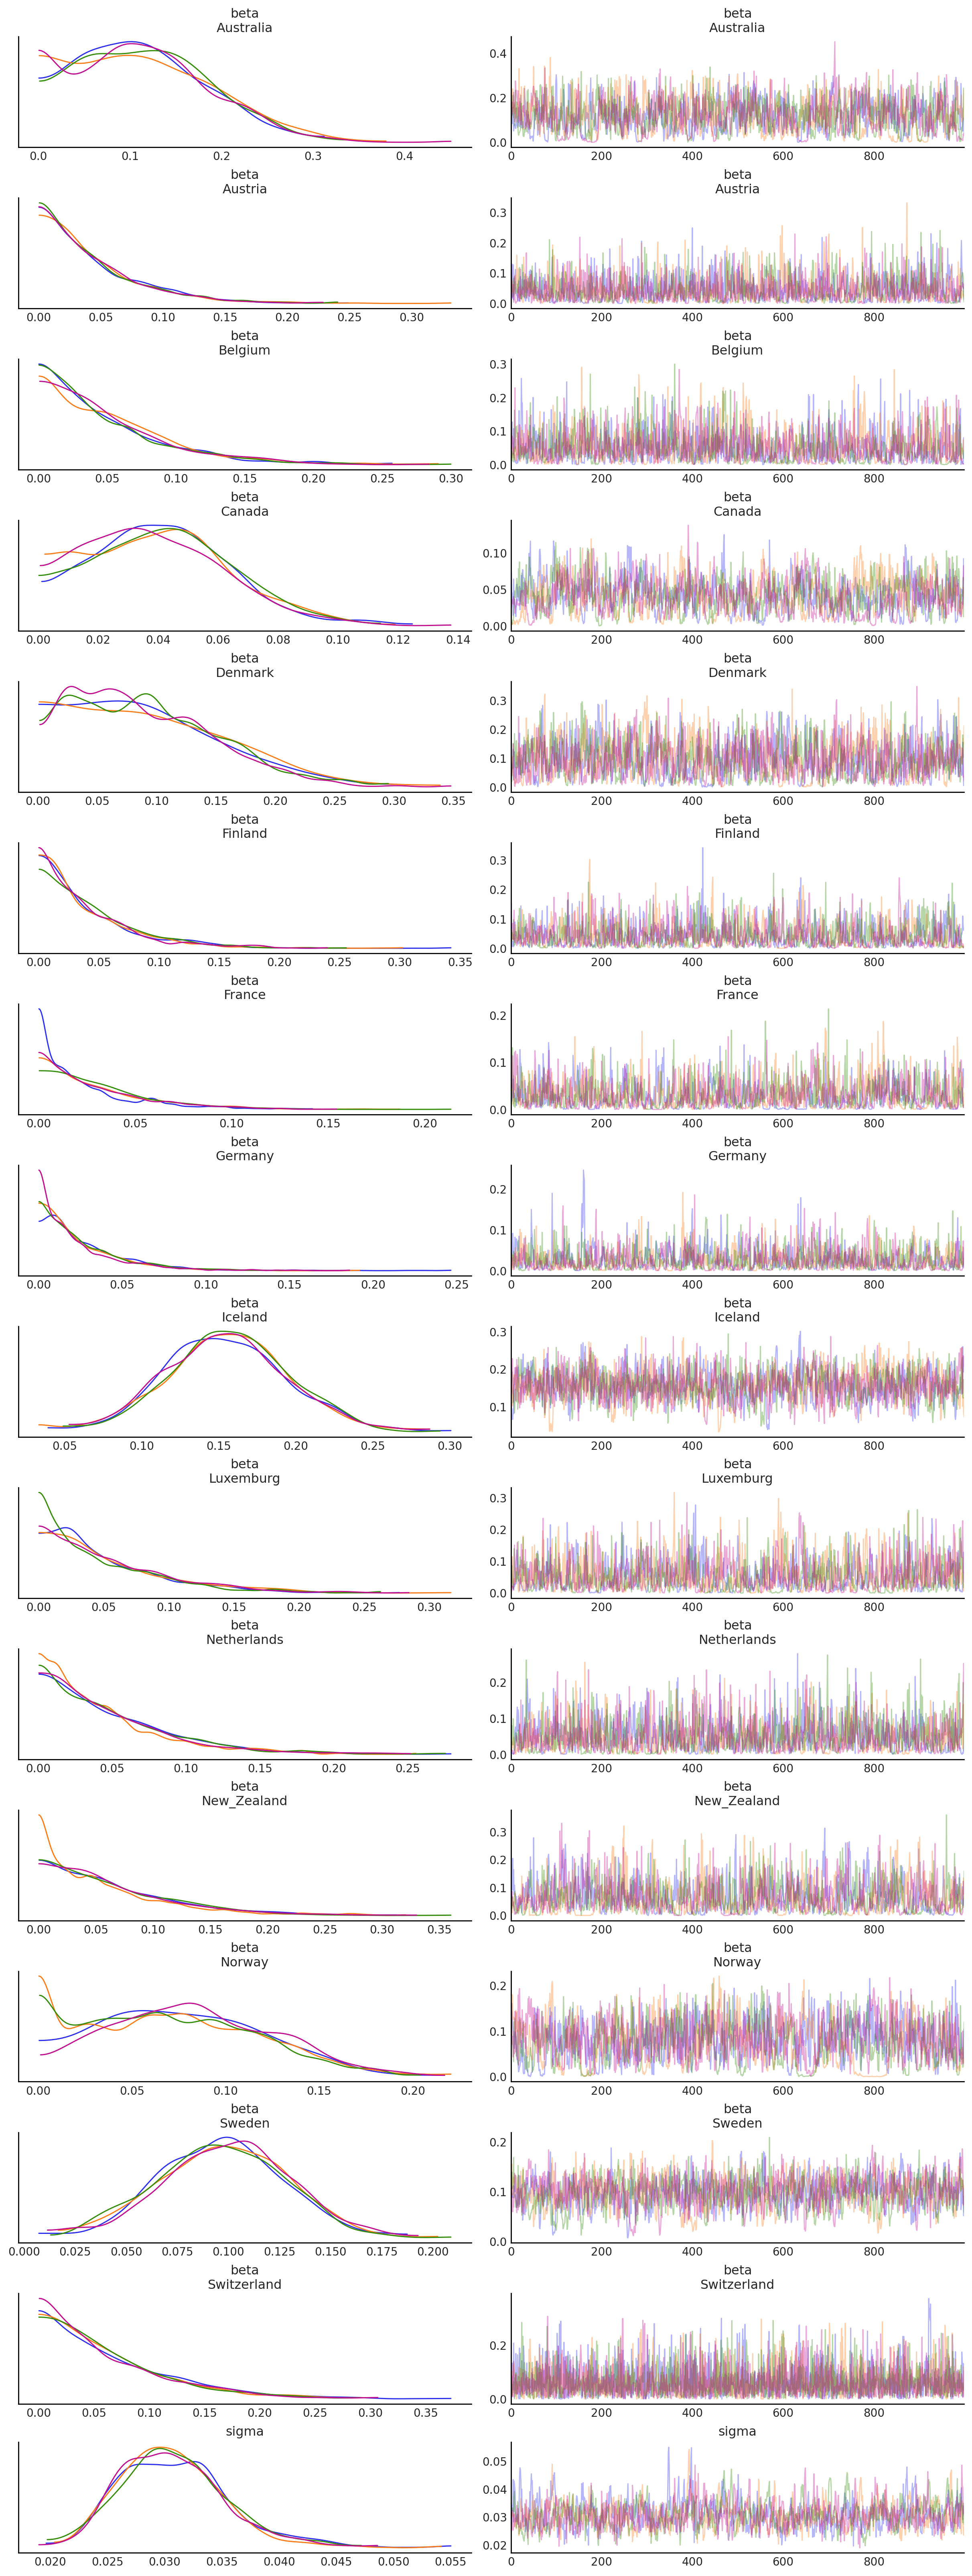

In [10]:
# Inpsect traces in more detail
az.plot_trace(result.idata, var_names="~mu", compact=False);

In [11]:
result.summary()

==================================Pre-Post Fit==================================
Formula: UK ~ 0 + Australia + Austria + Belgium + Canada + Denmark + Finland + France + Germany + Iceland + Luxemburg + Netherlands + New_Zealand + Norway + Sweden + Switzerland
Model coefficients:
Australia                     0.12, 94% HDI [0.01, 0.26]
Austria                       0.04, 94% HDI [0.00, 0.14]
Belgium                       0.05, 94% HDI [0.00, 0.16]
Canada                        0.04, 94% HDI [0.01, 0.09]
Denmark                       0.09, 94% HDI [0.01, 0.23]
Finland                       0.04, 94% HDI [0.00, 0.14]
France                        0.03, 94% HDI [0.00, 0.10]
Germany                       0.03, 94% HDI [0.00, 0.09]
Iceland                       0.16, 94% HDI [0.08, 0.23]
Luxemburg                     0.05, 94% HDI [0.00, 0.17]
Netherlands                   0.05, 94% HDI [0.00, 0.15]
New_Zealand                   0.06, 94% HDI [0.00, 0.20]
Norway                        0.08, 9

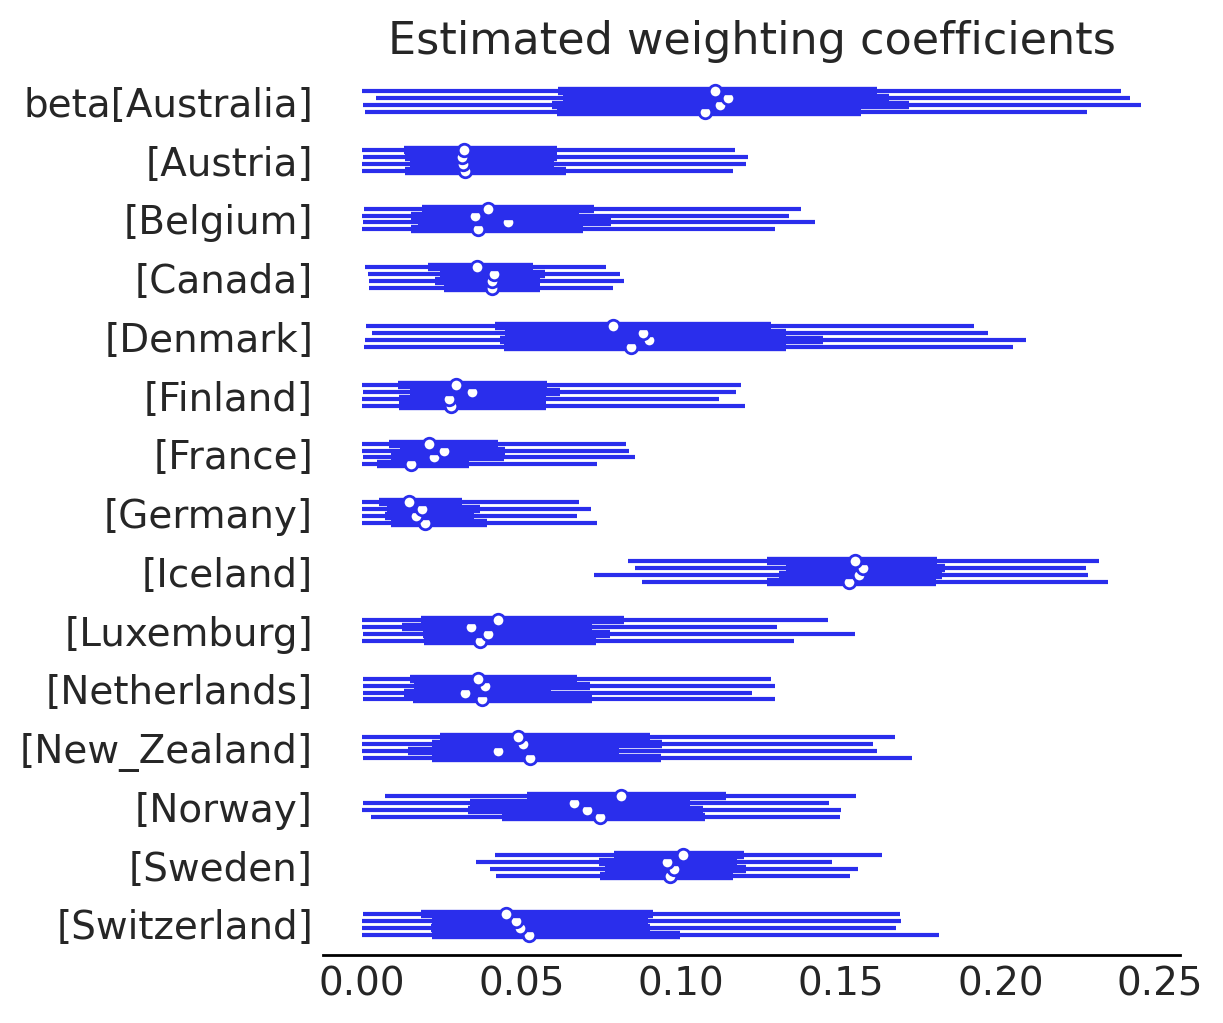

In [12]:
ax = az.plot_forest(result.idata, var_names="beta", figsize=(6, 5))
ax[0].set(title="Estimated weighting coefficients");

### Plot results

The `.plot()` method will generate 3 plots: 
1. Shows the pre/post intervention period and compare the actual observations with the causal impact
2. Shows the casual effect as the difference between the counterfactual and the actual observed outcome
3. Cumulative effect of the intervention

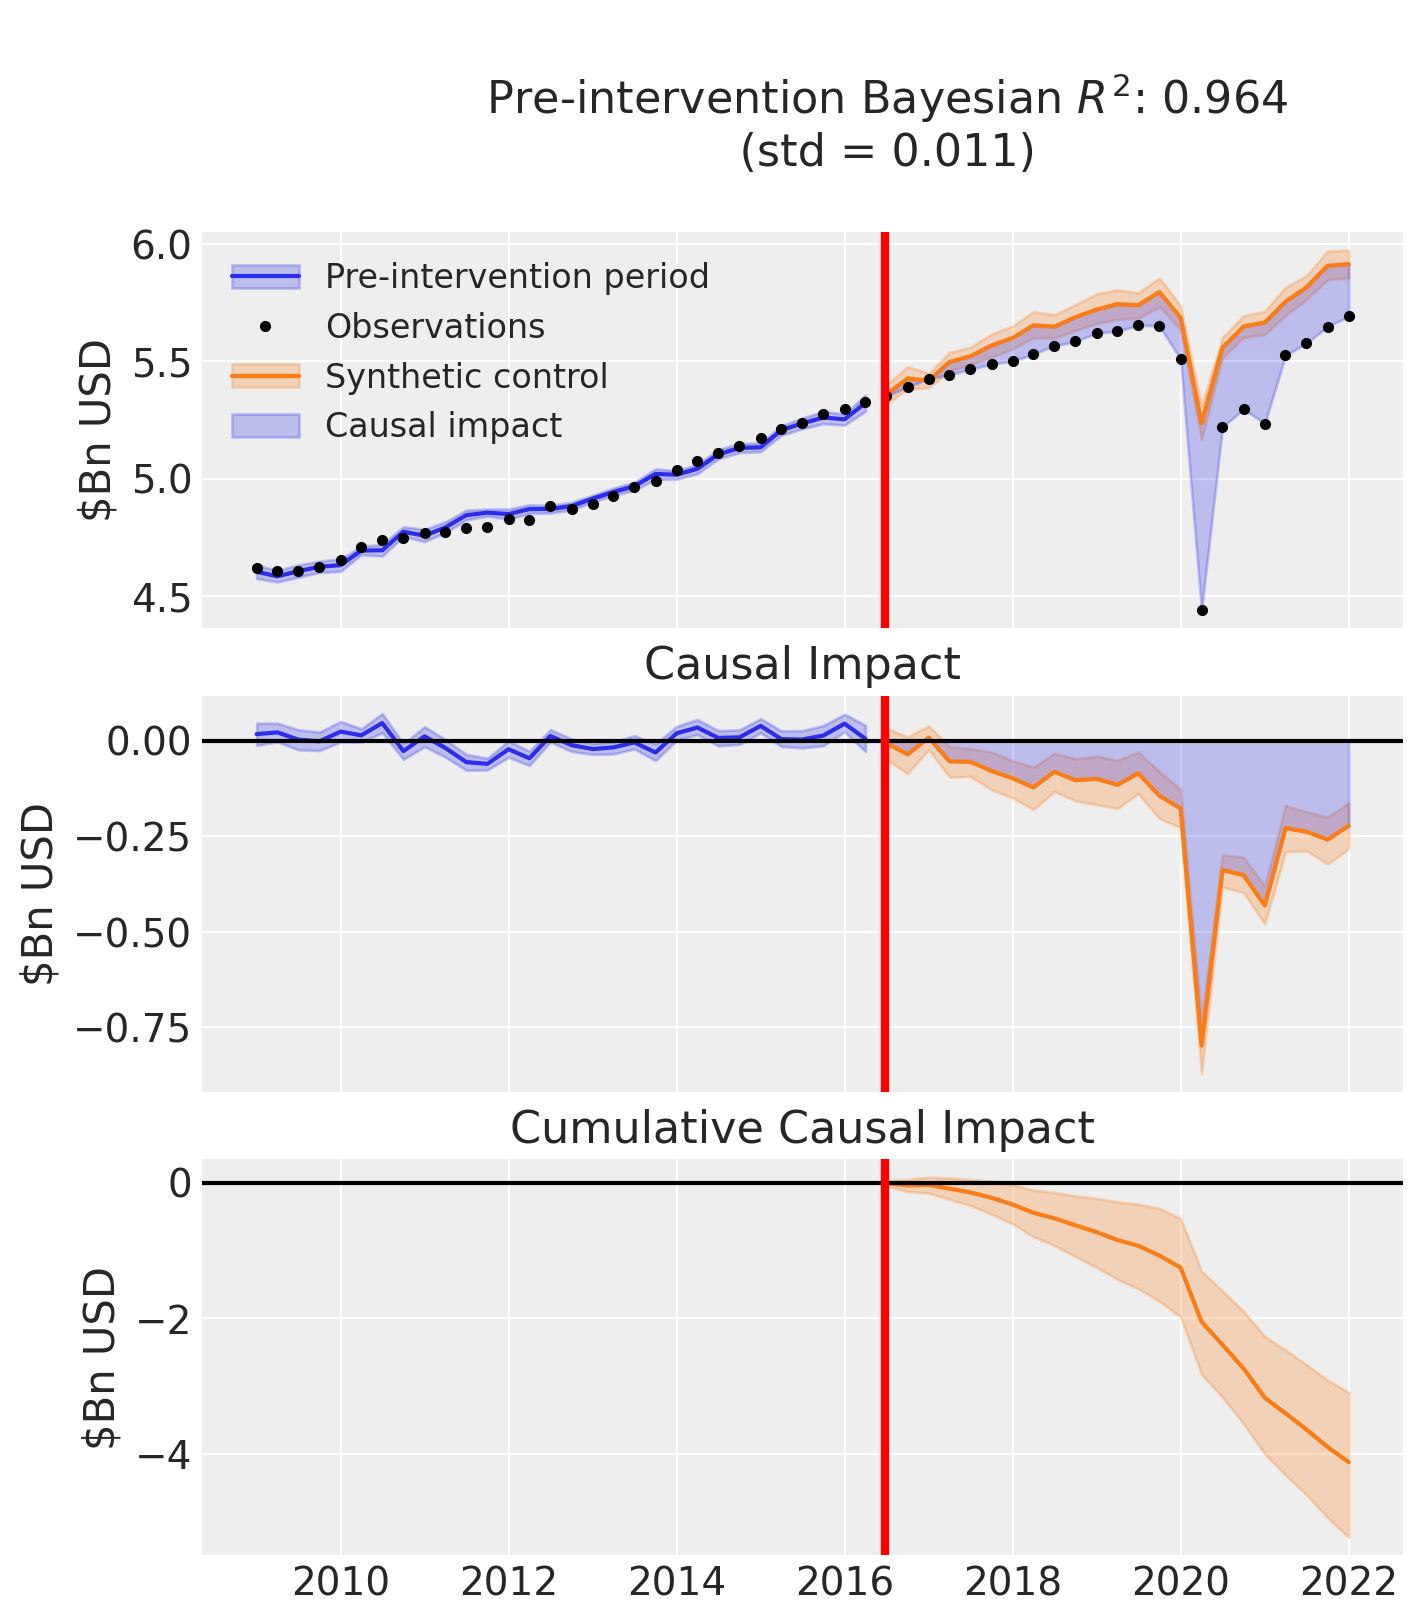

In [13]:
az.style.use("arviz-darkgrid")

fig, ax = result.plot(plot_predictors=False)

for i in [0, 1, 2]:
    ax[i].set(ylabel="$Bn USD")

## Another Example

Using the `sc` synthetic control dataset:

In [14]:
sc = cp.load_data("sc")
sc.head()

a         b         c         d         e         f         g  \
0  0.793234  1.277264 -0.055407 -0.791535  1.075170  0.817384 -2.607528   
1  1.841898  1.185068 -0.221424 -1.430772  1.078303  0.890110 -3.108099   
2  2.867102  1.922957 -0.153303 -1.429027  1.432057  1.455499 -3.149104   
3  2.816255  2.424558  0.252894 -1.260527  1.938960  2.088586 -3.563201   
4  3.865208  2.358650  0.311572 -2.393438  1.977716  2.752152 -3.515991   

   counterfactual  causal effect    actual  
0        0.144888           -0.0  0.398287  
1        0.601862           -0.0  0.491644  
2        1.060285           -0.0  1.232330  
3        1.520801           -0.0  1.672995  
4        1.983661           -0.0  1.775940

In [15]:
# Note, we do not want an intercept in this model

treatment_time = 70
result = cp.pymc_experiments.SyntheticControl(
    sc,
    treatment_time,
    formula="actual ~ 0 + a + b + c + d + e + f + g",
    model=WeightedSumFitter(
        sample_kwargs={"target_accept": 0.95, "random_seed": 42}
    ),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


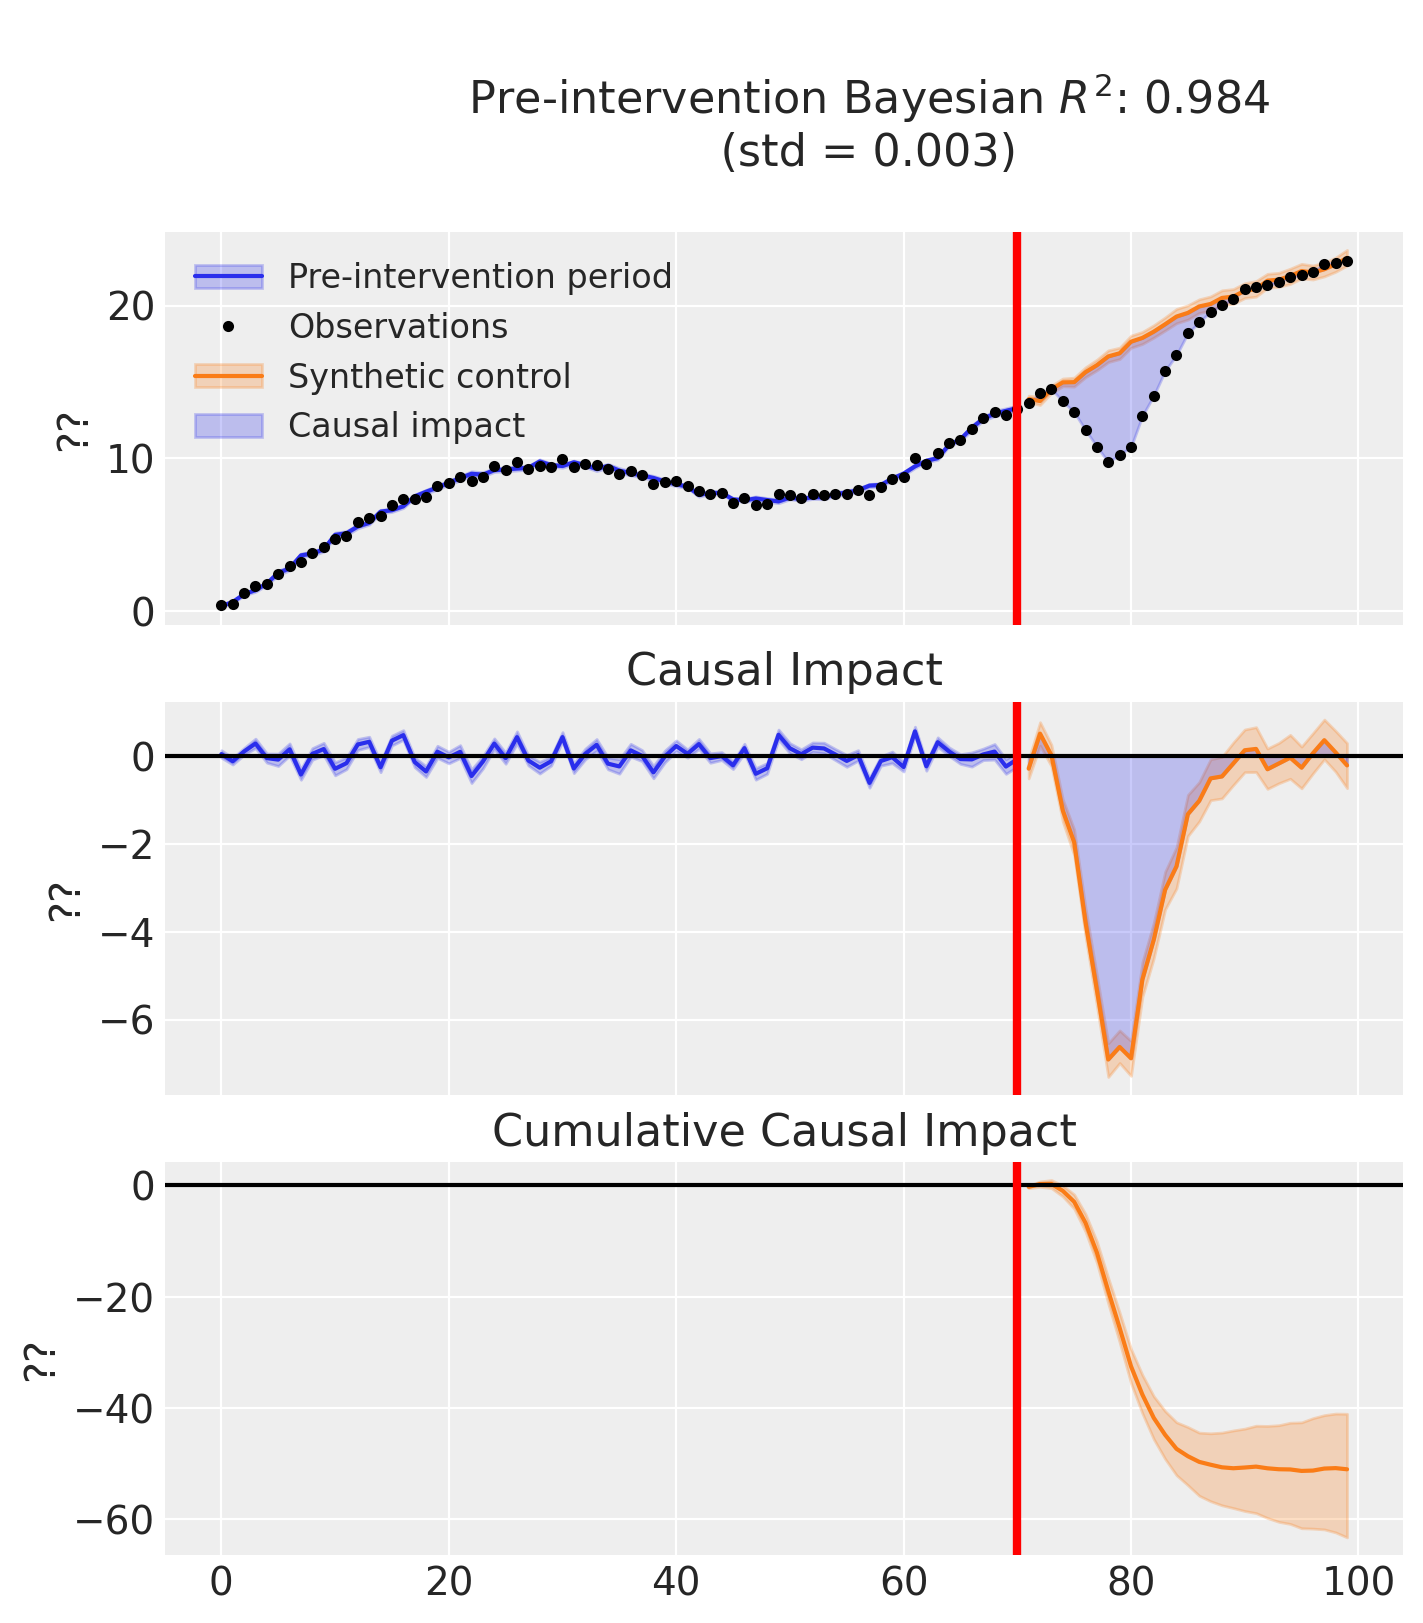

In [16]:
fig, ax = result.plot(plot_predictors=False)

for i in [0, 1, 2]:
    ax[i].set(ylabel="??")

In [17]:
result.summary()

==================================Pre-Post Fit==================================
Formula: actual ~ 0 + a + b + c + d + e + f + g
Model coefficients:
a                             0.34, 94% HDI [0.30, 0.38]
b                             0.05, 94% HDI [0.01, 0.09]
c                             0.31, 94% HDI [0.26, 0.35]
d                             0.06, 94% HDI [0.01, 0.10]
e                             0.03, 94% HDI [0.00, 0.07]
f                             0.19, 94% HDI [0.11, 0.26]
g                             0.04, 94% HDI [0.00, 0.09]
sigma                         0.26, 94% HDI [0.22, 0.30]


In [18]:
# Better summary:
az.summary(result.post_impact.mean('obs_ind'))

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
x -1.758  0.205   -2.18   -1.415      0.006    0.004    1284.0    1818.0   

   r_hat  
x   1.01

Cumulative impact:

In [19]:
# get index of the final time point
index = result.post_impact_cumulative.obs_ind.max()
# grab the posterior distribution of the cumulative impact at this final time point
last_cumulative_estimate = result.post_impact_cumulative.sel({"obs_ind": index})
# get summary stats
az.summary(last_cumulative_estimate)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
x -50.995  5.936 -63.224  -41.027      0.164    0.116    1284.0    1818.0   

   r_hat  
x   1.01